In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [13]:
import pathlib

# Replace 'local_path' with the local directory where you have downloaded and extracted the dataset.
local_path = "dataset"
data_dir = pathlib.Path(local_path)

In [14]:
print(data_dir)

dataset


In [15]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 960 files belonging to 2 classes.
Using 768 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 960 files belonging to 2 classes.
Using 192 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['no', 'yes']


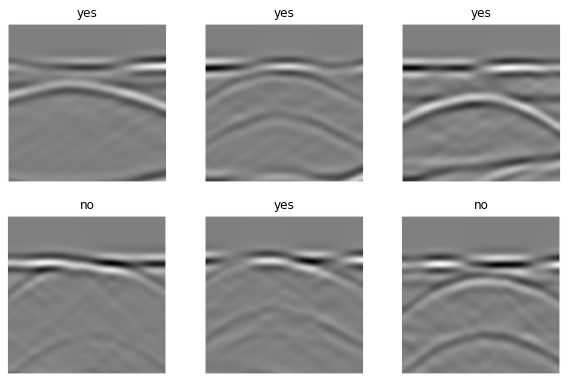

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [19]:
resnet_model = Sequential()

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=2,
                   weights='imagenet')

for layer in pretrained_model.layers[:-2]:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(512, activation='sigmoid'))
resnet_model.add(Dense(2, activation='sigmoid'))

In [20]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_4 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 module_wrapper_5 (ModuleWr  (None, 1024)              2098176   
 apper)                                                          
                                                                 
 module_wrapper_6 (ModuleWr  (None, 512)               524800    
 apper)                                                          
                                                                 
 module_wrapper_7 (ModuleWr  (None, 2)                 1026      
 apper)                                               

In [21]:
from keras.optimizers.legacy import Adam

# Define the learning rate
learning_rate = 0.001

# Create the optimizer with the desired learning rate
adam_optimizer = Adam(lr=learning_rate)
resnet_model.compile(optimizer=adam_optimizer, loss="sparse_categorical_crossentropy",metrics=['accuracy'])

In [22]:

epochs=50
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)


Epoch 1/50


24/24 [==============================] - 52s 2s/step - loss: 0.6945 - accuracy: 0.6797 - val_loss: 0.4210 - val_accuracy: 0.8229
Epoch 2/50
24/24 [==============================] - 45s 2s/step - loss: 0.3388 - accuracy: 0.8555 - val_loss: 0.2891 - val_accuracy: 0.8646
Epoch 3/50
24/24 [==============================] - 44s 2s/step - loss: 0.2305 - accuracy: 0.9115 - val_loss: 0.1924 - val_accuracy: 0.9219
Epoch 4/50
24/24 [==============================] - 46s 2s/step - loss: 0.1399 - accuracy: 0.9557 - val_loss: 0.1670 - val_accuracy: 0.9323
Epoch 5/50
24/24 [==============================] - 45s 2s/step - loss: 0.1019 - accuracy: 0.9701 - val_loss: 0.1267 - val_accuracy: 0.9583
Epoch 6/50
24/24 [==============================] - 51s 2s/step - loss: 0.0652 - accuracy: 0.9779 - val_loss: 0.2548 - val_accuracy: 0.9167
Epoch 7/50
24/24 [==============================] - 54s 2s/step - loss: 0.0910 - accuracy: 0.9688 - val_loss: 0.1243 - val_accuracy: 0.9479
Epoch 8/50
24/24 [=============

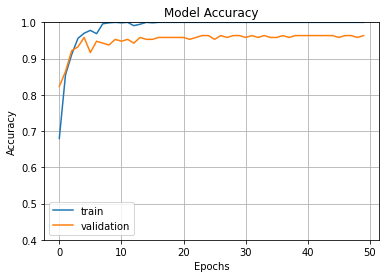

In [23]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

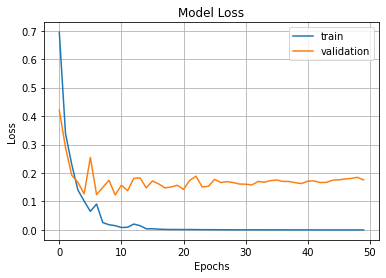

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: 
Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

# Assuming class_names variable is defined as the list of class names

# Load the trained model (ensure to replace 'your_model.h5' with the actual path to your saved model)
model = tf.keras.models.load_model('resNet.h5')

# Assuming val_ds is your validation dataset
y_pred = []
y_true = []
for images, labels in val_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Calculate the classification metrics
report = classification_report(y_true, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_true, y_pred)

print(report)
print(conf_matrix)
